In [216]:
import pandas as pd
import numpy as np
import math
import json
import re
from sklearn.externals import joblib
from collections import defaultdict
from scipy import sparse
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, accuracy_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision = 4, suppress = True)
plt.style.use('seaborn-whitegrid')

In [69]:
main = pd.read_csv('../WebScraping/edaru_main.csv')
breakfast = pd.read_csv('../WebScraping/edaru_breakfast.csv')
eda = pd.concat([main, breakfast], ignore_index=True)
eda.shape

(3640, 11)

In [70]:
ingredients = {}
for ings in eda.loc[:, 'ingredients'].values:
    for i in eval(ings):
        ingredients[eval(i)['id']] = eval(i)['name']

In [71]:
len(ingredients)

1672

In [72]:
with open('ingredients_total.json', 'w') as f:
    json.dump(ingredients, f)

In [73]:
recipes_index = {}
for i in range(eda.shape[0]):
    recipes_index[i] = eda.iloc[i, 2]

In [74]:
with open('recipes_index.json', 'w') as f:
    json.dump(recipes_index, f)

In [75]:
eda['us'] = np.where(eda.cuisine.str.contains('Американская', na=False), 1, 0) # na=False returns 0 when nan
eda.us = eda.us.astype('category')

In [76]:
eda['eu'] = np.where(eda.cuisine.str.contains('Европейская', na=False), 1, 0) # na=False returns 0 when nan
eda.us = eda.us.astype('category')
eda['ru'] = np.where(eda.cuisine.str.contains('Русская', na=False), 1, 0) # na=False returns 0 when nan
eda.us = eda.us.astype('category')

In [77]:
eda.stepbystep = eda.stepbystep.astype('category')

In [78]:
print(f'out of {eda.shape[0]} recipes, {eda.cuisine.isna().sum()} \
({round(100*eda.cuisine.isna().sum()/eda.shape[0], 1)}%) are missing cuisine')
print(f'american: {eda[eda.us == 1].shape[0]}\n\
european: {eda[eda.eu == 1].shape[0]}\n\
russian: {eda[eda.ru == 1].shape[0]}')
print(f'step by step: {eda[eda.stepbystep == 1].shape[0]}')
print(f'{eda.time.isna().sum()} missing time') # use average? median? 

out of 3640 recipes, 899 (24.7%) are missing cuisine
american: 164
european: 703
russian: 575
step by step: 174
329 missing time


In [79]:
eda.time = eda.time.fillna(0)

In [80]:
# substitute 0s for average
minutes = []
hour = re.compile('час')
mins = re.compile('минут')
for time in eda.loc[:, 'time'].values:
    if time == 0:
        minutes.append(0)
        
    else:
        
        # if end with hours
        if hour.search(time.split(' ')[-1]):
            t = int(time.split(' ')[-2])*60
            minutes.append(t)
            
        
        # if ends with minutes
        elif mins.search(time.split(' ')[-1]):
            t = int(time.split(' ')[-2])
        
            # check if contains hours
            try:
                t += int(time.split(' ')[-4])*60
                minutes.append(t)
            except IndexError:
                minutes.append(t)
median = np.median(minutes)
print(f'mean = {round(np.mean(minutes),1)}\nmedian = {np.median(minutes)}')

eda['minutes'] = [minute if minute else median for minute in minutes]

mean = 39.6
median = 30.0


In [157]:
edacopy = eda.loc[:, ['portions', 'ingredients', 'minutes']]

In [82]:
edacopy.head()

,portions,ingredients,minutes
0,4,"['{""id"": 13639, ""name"": ""Куриная грудка"", ""amo...",45.0
1,4,"['{""id"": 13544, ""name"": ""Куриное филе"", ""amoun...",30.0
2,4,"['{""id"": 13469, ""name"": ""Говядина"", ""amount"": ...",30.0
3,2,"['{""id"": 13484, ""name"": ""Макароны"", ""amount"": ...",20.0
4,5,"['{""id"": 13509, ""name"": ""Шампиньоны"", ""amount""...",35.0


In [83]:
s = set()
for ings in edacopy.loc[:, 'ingredients'].values:
    for i in eval(ings):
        s.add(' '.join(eval(i)['amount'].split(' ')[1:]))
s

{'',
 'банка',
 'банки',
 'веточек',
 'веточка',
 'веточки',
 'вкусу',
 'г',
 'головка',
 'головки',
 'головок',
 'зубчик',
 'зубчика',
 'зубчиков',
 'кг',
 'кончике ножа',
 'куска',
 'кусков',
 'кусок',
 'л',
 'мл',
 'пучка',
 'пучков',
 'пучок',
 'стакан',
 'стакана',
 'стаканов',
 'стебель',
 'стеблей',
 'стебля',
 'столовая ложка',
 'столовой ложки',
 'столовые ложки',
 'столовых ложек',
 'чайная ложка',
 'чайной ложки',
 'чайные ложки',
 'чайных ложек',
 'штук',
 'штука',
 'штуки'}

In [128]:
# create a sparse df w/ ingredients
for i in sorted(list(ingredients.keys())):
    edacopy[str(i)] = 0

In [129]:
edacopy.head() 

,portions,ingredients,minutes,13406,13407,13408,13409,13410,13411,13412,...,43787,43915,43984,45004,45280,56688,56926,57371,57500,58517
0,4,"['{""id"": 13639, ""name"": ""Куриная грудка"", ""amo...",45.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,"['{""id"": 13544, ""name"": ""Куриное филе"", ""amoun...",30.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,"['{""id"": 13469, ""name"": ""Говядина"", ""amount"": ...",30.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,"['{""id"": 13484, ""name"": ""Макароны"", ""amount"": ...",20.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,"['{""id"": 13509, ""name"": ""Шампиньоны"", ""amount""...",35.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Веса продуктов

яйцо = 50г

яблоко = 175г

банан = 200г

стакан сахара/муки = 160г

столовая ложка = 20г

чайная ложка = 5г

банка сметаны = 200г

кусок = 200г

кусок шоколада = 50г

головка лука = 85г

головка чеснока = 45г

зубчик = 10г

стебель = 60г

по вкусу = 0г

на кончике ножа = 0г

щепотка = 0г

мл = г

л = 1000г

In [116]:
eval(edacopy.loc[0, 'ingredients'])

['{"id": 13639, "name": "Куриная грудка", "amount": "4 штуки"}',
 '{"id": 15371, "name": "Лук", "amount": "2 штуки"}',
 '{"id": 13467, "name": "Сладкий перец", "amount": "3 штуки"}',
 '{"id": 13430, "name": "Чеснок", "amount": "3 зубчика"}',
 '{"id": 13439, "name": "Помидоры", "amount": "4 штуки"}',
 '{"id": 15509, "name": "Овощной бульонный кубик ", "amount": "1 штука"}',
 '{"id": 13426, "name": "Сыр", "amount": "100 г"}',
 '{"id": 15594, "name": "Смесь итальянских трав", "amount": "1 столовая ложка"}',
 '{"id": 13411, "name": "Вода", "amount": "½ стакана"}',
 '{"id": 13474, "name": "Сливки", "amount": "½ стакана"}',
 '{"id": 13513, "name": "Оливковое масло", "amount": "2 столовые ложки"}',
 '{"id": 13615, "name": "Мускатный орех", "amount": "щепотка"}',
 '{"id": 13421, "name": "Соль", "amount": "по вкусу"}',
 '{"id": 13412, "name": "Сливочное масло", "amount": "1 столовая ложка"}',
 '{"id": 13420, "name": "Перец черный молотый", "amount": "по вкусу"}']

In [159]:
# for each row extract ingredients
for n in range(edacopy.shape[0]):
    minutes = edacopy.loc[n, 'minutes']
    edacopy.loc[n, 'minutes'] = np.log(minutes)
    for i in eval(edacopy.loc[n, 'ingredients']):

        # if grams or ml
        if eval(i)['amount'].split(' ')[-1] == 'г' or eval(i)['amount'].split(' ')[-1] == 'мл':
            try:
                value = int(eval(i)['amount'].split(' ')[-2])
            # has a comma
            except ValueError:
                try:
                    value = int(''.join(eval(i)['amount'].split(' ')[-2].split(',')))
                # a stupid fraction of a gram
                except ValueError:
                    value = 0

        # if kg or l
        elif eval(i)['amount'].split(' ')[-1] == 'кг' or eval(i)['amount'].split(' ')[-1] == 'л':
            try:
                value = int(eval(i)['amount'].split(' ')[-2])*1000
            # has a comma
            except ValueError:
                try:
                    value = float('.'.join(eval(i)['amount'].split(' ')[-2].split(',')))*1000
                # a stupid fraction of a gram
                except ValueError:
                    value = 500
        # по вкусу
        elif re.compile('вкус').search(eval(i)['amount']) or re.compile('нож').search(eval(i)['amount'])\
                or re.compile('щепотка').search(eval(i)['amount']):
            value = 0

        # if an egg
        elif re.compile('йцо').search(eval(i)['name']) or re.compile('желт').search(eval(i)['name'])\
                or re.compile('белок').search(eval(i)['name']):
            try:
                value =  int(eval(i)['amount'][0])*50
            except ValueError:
                value = 25

        # if a banana
        elif re.compile('анан').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*200
            # a stupid fraction 
            except ValueError:
                value = 100

        # if an apple:
        elif re.compile('блоко').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*175
            # a stupid fraction
            except ValueError:
                value =  100

        # if a glass
        elif re.compile('стакан').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*160
            # a stupid fraction
            except ValueError:
                value = 100

        # table spoon
        elif re.compile('стол').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*20
            # a stupid fraction
            except ValueError:
                value = 10

        # tea spoon
        elif re.compile('чайн').search(eval(i)['amount']):
            try:
                 value = int(eval(i)['amount'][0])*5
            # a stupid fraction
            except ValueError:
                value = 3

        # can
        elif re.compile('банк').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*200
            # has a comma
            except ValueError:
                try:
                    value = float('.'.join(eval(i)['amount'].split(' ')[0].split(',')))*200
                # a stupid fraction
                except ValueError:
                     value = 100

        # chocolate
        elif re.compile('околад').search(eval(i)['name']):
            value = int(eval(i)['amount'][0])*20

        # остальные куски
        elif re.compile('кус').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*200 
            except ValueError:
                value = 100

        # зубчики
        elif re.compile('зубч').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*10
            except ValueError:
                value = 5

        # головка лука
        elif re.compile('головк').search(eval(i)['amount']) and re.compile('ук').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*85 
            except ValueError:
                value = 40

        # головка чеснока
        elif re.compile('головк').search(eval(i)['amount']) and re.compile('еснок').search(eval(i)['name']):
            try:
                value = int(eval(i)['amount'][0])*45
            except ValueError:
                value = 20

         # стебли веточки
        elif re.compile('стеб').search(eval(i)['amount']) or re.compile('веточ').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*20
            except ValueError:
                value = 10

        # ваниль корица печенье фундук пучки головки
        elif re.compile('аниль').search(eval(i)['name']) or re.compile('ориц').search(eval(i)['name']) or\
            re.compile('ечень').search(eval(i)['name']) or re.compile('ундук').search(eval(i)['name']) or\
            re.compile('пуч').search(eval(i)['amount']) or re.compile('голов').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'][0])*20
            except ValueError:
                value = 10

        # remainig items
        elif re.compile('штук').search(eval(i)['amount']):
            try:
                value = int(eval(i)['amount'].split(' ')[0])*150
            except ValueError:
                try:
                    value = int(''.join(eval(i)['amount'].split(' ')[0].split(',')))*150
                # a stupid fraction of a gram
                except ValueError:
                    value = 100

        else:
            print(i)

        portions = edacopy.loc[n, 'portions']
        value /= portions
        
        value = np.log(value) if value else 0
        edacopy.loc[n, str(eval(i)['id'])] = value
        
print('finished')

finished


In [89]:
# save ingredients indices for future desciphering
ings_index = {}
num = 0
for i in sorted(list(ingredients.keys())):
    ings_index[i] = num
    num += 1

In [90]:
with open('ings_index_total.json', 'w') as f:
    json.dump(ings_index, f)

In [160]:
edacopy.drop(columns=['ingredients', 'portions'], inplace=True)

In [161]:
edacopy.fillna(value=0, inplace=True)

In [162]:
edacopy.head()

,minutes,13639,15371,13467,13430,13439,15509,13426,15594,13411,...,16113,15322,16344,15168,14484,24019,24093,14265,28466,15317
0,3.806662,5.010635,4.317488,4.722953,2.014903,5.010635,3.624341,3.218876,1.609438,3.218876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.401197,0.000000,0.000000,3.624341,0.000000,4.317488,0.000000,0.000000,0.000000,3.218876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.401197,0.000000,0.000000,0.000000,2.014903,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.995732,0.000000,0.000000,0.000000,1.609438,4.317488,0.000000,3.912023,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.555348,0.000000,0.000000,2.995732,0.000000,2.995732,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
# convert to condenced sparse row
edamtx = sparse.csr_matrix(edacopy)

In [145]:
scores = []
for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(edamtx)
    centers = clusterer.cluster_centers_

    score = silhouette_score(edamtx, preds, metric='euclidean')
    scores.append(score)
    print (f"For n_clusters = {n_clusters}, silhouette score is {round(score, 3)}")

For n_clusters = 2, silhouette score is 0.036
For n_clusters = 3, silhouette score is 0.045
For n_clusters = 4, silhouette score is 0.024
For n_clusters = 5, silhouette score is 0.029
For n_clusters = 6, silhouette score is 0.021
For n_clusters = 7, silhouette score is 0.024
For n_clusters = 8, silhouette score is 0.029
For n_clusters = 9, silhouette score is 0.031
For n_clusters = 10, silhouette score is 0.029


In [146]:
for n_clusters in range(11, 21):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(edamtx)
    centers = clusterer.cluster_centers_

    score = silhouette_score(edamtx, preds, metric='euclidean')
    scores.append(score)
    print (f"For n_clusters = {n_clusters}, silhouette score is {round(score, 3)}")

For n_clusters = 11, silhouette score is 0.034
For n_clusters = 12, silhouette score is 0.036
For n_clusters = 13, silhouette score is 0.035
For n_clusters = 14, silhouette score is 0.032
For n_clusters = 15, silhouette score is 0.038
For n_clusters = 16, silhouette score is 0.035
For n_clusters = 17, silhouette score is 0.033
For n_clusters = 18, silhouette score is 0.039
For n_clusters = 19, silhouette score is 0.029
For n_clusters = 20, silhouette score is 0.033


In [101]:
for n_clusters in range(21, 31):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(edamtx)
    centers = clusterer.cluster_centers_

    score = silhouette_score(edamtx, preds, metric='euclidean')
    scores.append(score)
    print (f"For n_clusters = {n_clusters}, silhouette score is {round(score, 3)}")

For n_clusters = 21, silhouette score is 0.138
For n_clusters = 22, silhouette score is 0.136
For n_clusters = 23, silhouette score is 0.105
For n_clusters = 24, silhouette score is 0.051
For n_clusters = 25, silhouette score is 0.151
For n_clusters = 26, silhouette score is 0.149
For n_clusters = 27, silhouette score is -0.021
For n_clusters = 28, silhouette score is -0.003
For n_clusters = 29, silhouette score is 0.109
For n_clusters = 30, silhouette score is 0.065


In [96]:
print(f'number of recipes: {edacopy.shape[0]}')

number of recipes: 3640


## Dendrograms

In [101]:
# if starting from here
edacopy = pd.read_csv('edacopy.csv')
edacopy.drop(columns='Unnamed: 0', inplace = True)

In [164]:
Z_ward = linkage(edacopy, 'ward') # Ward variance minimization algorithm
Z_single = linkage(edacopy, 'single') # Nearest Point Algorithm
Z_complete = linkage(edacopy, 'complete') # Farthest Point Algorithm
Z_average = linkage(edacopy, 'average') # UPGMA algorithm

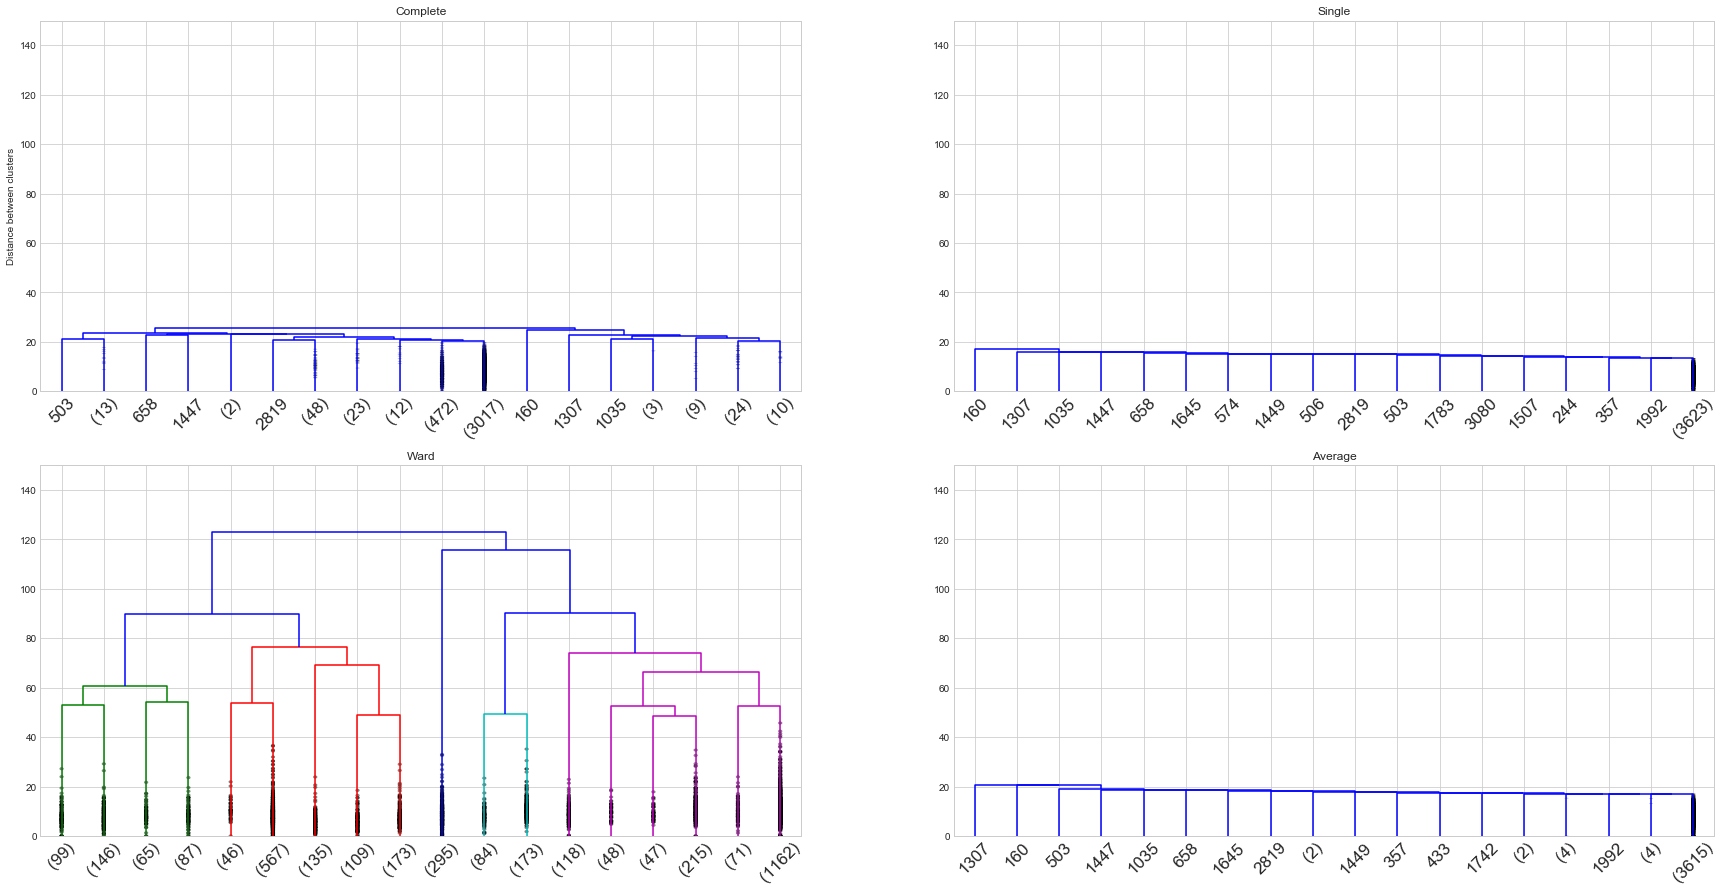

In [165]:
plt.figure(figsize=(30, 15))

plt.subplot(221)
dendrogram(Z_complete, truncate_mode='lastp', leaf_rotation=45., p=18, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 150))
plt.title('Complete')
plt.ylabel('Distance between clusters')

plt.subplot(222)
dendrogram(Z_single, truncate_mode='lastp', leaf_rotation=45., p=18, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 150))
plt.title('Single')

plt.subplot(223)
dendrogram(Z_ward, truncate_mode='lastp', leaf_rotation=45., p=18, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 150))
plt.title('Ward')

plt.subplot(224)
dendrogram(Z_average, truncate_mode='lastp', leaf_rotation=45., p=18, leaf_font_size=17., show_contracted=True)
plt.ylim((0, 150))
plt.title('Average')


plt.show()

In [183]:
hclustering_ward = AgglomerativeClustering(linkage='ward', n_clusters=50)
hclustering_ward.fit(edacopy)
c = {i:0 for i in range(50)}
for i in hclustering_ward.labels_:
    c[i] += 1
total = 0
for i, v in c.items():
    total += v
    print(f'{i}: {v}')
print(total)

0: 48
1: 198
2: 242
3: 93
4: 328
5: 87
6: 82
7: 50
8: 73
9: 85
10: 47
11: 46
12: 92
13: 31
14: 19
15: 135
16: 84
17: 56
18: 46
19: 312
20: 73
21: 39
22: 86
23: 26
24: 84
25: 147
26: 26
27: 118
28: 12
29: 22
30: 48
31: 27
32: 23
33: 24
34: 109
35: 18
36: 47
37: 24
38: 19
39: 24
40: 53
41: 46
42: 58
43: 67
44: 65
45: 15
46: 66
47: 35
48: 59
49: 26
3640


In [191]:
kmeans = KMeans(n_clusters=45)
kmeans.fit_predict(edamtx)


array([16, 13, 40, ..., 37, 36, 37], dtype=int32)

In [192]:
c = {i: 0 for i in range(45)}
for i in kmeans.labels_:
    c[i] += 1
total = 0
for i, v in c.items():
    total += v
    print(f'{i}: {v}')
print(total)

0: 20
1: 56
2: 49
3: 88
4: 121
5: 71
6: 312
7: 18
8: 150
9: 98
10: 37
11: 88
12: 40
13: 109
14: 88
15: 108
16: 86
17: 102
18: 61
19: 106
20: 80
21: 53
22: 153
23: 61
24: 101
25: 102
26: 22
27: 29
28: 142
29: 23
30: 18
31: 47
32: 1
33: 42
34: 60
35: 145
36: 48
37: 368
38: 10
39: 57
40: 74
41: 13
42: 143
43: 29
44: 11
3640


In [199]:
# "new" data
newdata = edacopy.loc[[3, 4], :]
kmeans.predict(newdata)


array([16, 36], dtype=int32)

In [214]:
kmeans.cluster_centers_

array([[3.2735, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [4.0301, 0.    , 0.1542, ..., 0.    , 0.    , 0.    ],
       [3.7069, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [3.3619, 0.    , 0.0672, ..., 0.    , 0.    , 0.    ],
       [3.6329, 0.2838, 0.748 , ..., 0.    , 0.    , 0.    ],
       [3.5677, 0.    , 0.    , ..., 0.    , 0.    , 0.    ]])

## Other models (work worse)

In [152]:
hclustering_complete = AgglomerativeClustering(linkage='complete', n_clusters=18)
hclustering_complete.fit_predict(edacopy)
c = {i:0 for i in range(18)}
for i in hclustering_complete.labels_:
    c[i] += 1
for i, v in c.items():
    print(f'{i}: {v}')

0: 125
1: 371
2: 3
3: 2867
4: 2
5: 2
6: 24
7: 2
8: 225
9: 8
10: 4
11: 1
12: 1
13: 1
14: 1
15: 1
16: 1
17: 1


In [153]:
hclustering_single = AgglomerativeClustering(linkage='single', n_clusters=18)
hclustering_single.fit_predict(edacopy)
c = {i:0 for i in range(18)}
for i in hclustering_single.labels_:
    c[i] += 1
for i, v in c.items():
    print(f'{i}: {v}')

0: 3623
1: 1
2: 1
3: 1
4: 1
5: 1
6: 1
7: 1
8: 1
9: 1
10: 1
11: 1
12: 1
13: 1
14: 1
15: 1
16: 1
17: 1


In [106]:
# edacopy.drop(columns='minutes', inplace=True)
idf = []
for i in range(len(edacopy.columns)):
    try:
        idf.append(round(math.log2(edacopy.shape[0]/edacopy[edacopy[edacopy.columns[i]] != 0].shape[0]), 2))
    except ZeroDivisionError:
        idf.append(1)

In [111]:
len(idf), len(edacopy.columns)

(775, 775)

In [112]:
for column in range(len(edacopy.columns)):
    for i in range(edacopy.shape[0]):
        edacopy.loc[i, edacopy.columns[column]] = edacopy.loc[i, edacopy.columns[column]]/idf[column] 

In [114]:
edacopy.to_csv('edatfidf.csv')

In [115]:
hclustering_ward_tfidf = AgglomerativeClustering(linkage='ward', n_clusters=10)
hclustering_ward.fit_predict(edacopy)
c = {i:0 for i in range(10)}
for i in hclustering_ward.labels_:
    c[i] += 1
for i, v in c.items():
    print(f'{i}: {v}')

0: 1760
1: 1
2: 1
3: 1
4: 1
5: 1
6: 1
7: 1
8: 1
9: 1
